### Importing Required Libraries

In [245]:
# Standard libraries for file handling and numerical operations
import os      
import random    
import numpy as np 
import pandas as pd  

# To Displays progress bars for loops
from tqdm import tqdm 

# Audio processing libraries
import librosa
import librosa.display  

# Visualization libraries
import seaborn as sns  
import matplotlib.pyplot as plt  

# To evaluate model performance using a confusion matrix
from sklearn.metrics import confusion_matrix  

# Preprocessing utilities
from sklearn.model_selection import train_test_split 
# Converts categorical labels to numerical labels 
from sklearn.preprocessing import LabelEncoder  
# Normalizes features to improve model performance
from sklearn.preprocessing import StandardScaler  

# Deep learning model training using TensorFlow Keras
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Dropout  
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten  

# Model evaluation utilities
from tensorflow.keras import models as tf_models  
from sklearn.metrics import classification_report

### Define Dataset Path

In [246]:
dataset_root = r"I:\My Drive"
dataset_subfolders = ["Audio_Speech_Actors_01-24", "Audio_Song_Actors_01-24"]

### Define emotions based on RAVDESS Dataset

In [247]:
emotion_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
               '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}

### Ensuring dataset_features directory exists

In [248]:
output_dir = r"I:\My Drive\SpeechEmotionDetection\dataset_features"
os.makedirs(output_dir, exist_ok=True)

### Audio Feature Extraction
This function extracts three key features from an audio file:
1. **MFCCs (Mel-Frequency Cepstral Coefficients)**
    - Captures timbral characteristics of speech.
    - Timbre refers to the quality or color of a sound that makes it distinct from other sounds, even when they have the same pitch and loudness.
2. **Chroma Features** 
    - Represents pitch class distribution in the audio.
3. **Mel Spectrogram** 
    - Shows energy distribution over different frequencies.

These features are essential for training a machine learning model to classify speech emotions

In [249]:
def extract_features(file_path):
    """Extracts audio features (MFCCs, Chroma, and Mel Spectrogram) from a given audio file.
    And returns a feature vector (numpy array) containing MFCCs, Chroma, and Mel Spectrogram.
    """
    y, sr = librosa.load(file_path, sr=None)

    # Extract MFCCs
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)

    # Extract Chroma
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)

    # Extract Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)

    return np.hstack([mfccs, chroma, mel])

### Dataset Processing

In [250]:
# Function to process a dataset folder
def process_dataset(dataset_path, category, data):
    """Processes audio files from a dataset directory, extracts features and stores them in strucuted list"""
    # List to store all file paths and names
    all_files = []
    # Iterate through each actor's folder inside the dataset directory
    for actor_folder in os.listdir(dataset_path):
        actor_path = os.path.join(dataset_path, actor_folder)
        
        # Ignore non-actor folder
        if not os.path.isdir(actor_path):
            continue

        # Iterate through audio files inside each actor's folder
        for file_name in os.listdir(actor_path):
            file_path = os.path.join(actor_path, file_name)

            # Ignore non-audio files 
            if not file_name.lower().endswith(".wav"):
                continue  # Skip non-audio files

            all_files.append((file_path, file_name))


    # Display processing of files found in the category
    print(f"Processing {category}: {len(all_files)} files")

    # Process each audio file and extract features
    for file_path, file_name in tqdm(all_files, desc=f"{category}"):
        try:
            features = extract_features(file_path)
            emotion_code = file_name.split("-")[2]
            emotion = emotion_map.get(emotion_code, "unknown")
            data.append([file_path, category, emotion] + features.tolist())
        except Exception as e:
            print(f"Error processing {file_name}: {e}")


In [251]:
# Initializing empty list to store extracted features
data = []

# Iterate through each subfolder in the dataset
for subfolder in dataset_subfolders:
    process_dataset(os.path.join(dataset_root, subfolder), subfolder, data)

# Check if feature extraction was successful
if data:
    # Define Dataframe to store metadata and extracted features
    columns = ["file_path", "category", "emotion"] + [f"feature_{i}" for i in range(len(data[0]) - 3)]
    df = pd.DataFrame(data, columns=columns)

    #Converting Dataframe to csv
    df.to_csv(os.path.join(output_dir, "audio_features.csv"), index=False)
    print("Feature extraction completed! Data saved to dataset_features/audio_features.csv")
else:
    print("No valid audio files found for feature extraction.")

Processing Audio_Speech_Actors_01-24: 1440 files


Audio_Speech_Actors_01-24: 100%|██████████| 1440/1440 [03:12<00:00,  7.47it/s]


Processing Audio_Song_Actors_01-24: 1012 files


Audio_Song_Actors_01-24: 100%|██████████| 1012/1012 [08:14<00:00,  2.05it/s]


Feature extraction completed! Data saved to dataset_features/audio_features.csv


In [252]:
# Load the saved CSV file for verification
df = pd.read_csv(r"I:\My Drive\SpeechEmotionDetection\dataset_features\audio_features.csv")

# Display Top 5 rows
df.head()

,file_path,category,emotion,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179
0,I:\My Drive\Audio_Speech_Actors_01-24\Actor_09...,Audio_Speech_Actors_01-24,disgust,-683.979553,89.553009,1.002610,12.814185,13.847642,15.458847,-5.636692,...,1.838574e-07,1.757045e-07,1.475160e-07,9.414156e-08,8.740297e-08,8.861492e-08,6.243140e-08,2.445380e-08,7.480933e-09,7.090482e-09
1,I:\My Drive\Audio_Speech_Actors_01-24\Actor_09...,Audio_Speech_Actors_01-24,fearful,-590.847839,63.929508,-0.203056,12.907093,5.051848,15.743986,-7.324590,...,1.114628e-06,8.043079e-07,7.851357e-07,5.055985e-07,4.639778e-07,4.841817e-07,3.481075e-07,1.276913e-07,1.381547e-08,7.907723e-09
2,I:\My Drive\Audio_Speech_Actors_01-24\Actor_09...,Audio_Speech_Actors_01-24,calm,-792.877991,84.402924,11.711248,22.659185,10.396310,20.110916,3.031713,...,1.451464e-08,9.801979e-09,6.760149e-09,5.788878e-09,5.774577e-09,5.857522e-09,5.546776e-09,5.300761e-09,5.366086e-09,5.390684e-09
3,I:\My Drive\Audio_Speech_Actors_01-24\Actor_09...,Audio_Speech_Actors_01-24,fearful,-625.412415,89.345726,2.360502,14.402076,15.371239,23.466177,-5.400414,...,4.581117e-07,4.393920e-07,3.803131e-07,2.345599e-07,1.345453e-07,1.192339e-07,8.506431e-08,4.392666e-08,1.047715e-08,8.753392e-09
4,I:\My Drive\Audio_Speech_Actors_01-24\Actor_09...,Audio_Speech_Actors_01-24,sad,-749.033630,101.306038,5.393279,22.513130,12.124167,22.545036,1.623664,...,2.016923e-08,1.952276e-08,1.379919e-08,1.239733e-08,1.305881e-08,1.108244e-08,8.529398e-09,8.023850e-09,6.985719e-09,6.711362e-09


### Plotting Sample Waveform and MFCC

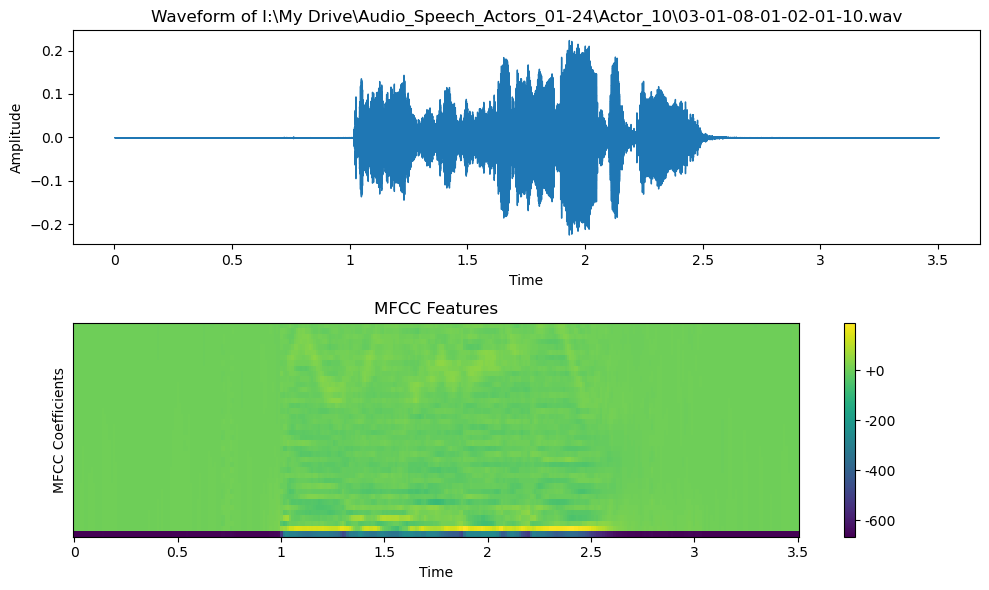

In [253]:
# Randomly select audio file from dataset
audio_file = random.choice(df['file_path'])

# Load audio file
y, sr = librosa.load(audio_file, sr=None)

# Compute MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

# Create a figure with subplots
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))

# Plot waveform
ax[0].set_title(f"Waveform of {audio_file.split('/')[-1]}")
librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")

# Plot MFCC features
img = librosa.display.specshow(mfccs, x_axis="time", sr=sr, ax=ax[1], cmap="viridis")
ax[1].set_title("MFCC Features")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("MFCC Coefficients")
fig.colorbar(img, ax=ax[1], format="%+2.f")
# Show plot
plt.tight_layout()
plt.show()

### Preprocessing Dataset

In [254]:
# Encoding emotions
print(df['emotion'])
label_encoder = LabelEncoder()
df["emotion"] = label_encoder.fit_transform(df["emotion"])
df['emotion']

0       disgust
1       fearful
2          calm
3       fearful
4           sad
         ...   
2447      angry
2448       calm
2449    fearful
2450      angry
2451      happy
Name: emotion, Length: 2452, dtype: object


0       2
1       3
2       1
3       3
4       6
       ..
2447    0
2448    1
2449    3
2450    0
2451    4
Name: emotion, Length: 2452, dtype: int64

In [255]:
# Defining columns to exclude non-feature columns
exclude_columns = ["emotion", "file_path", "category"]

In [256]:
# Split data into features and labels
X = df.drop(columns=exclude_columns, axis=1)
y = df["emotion"]

In [257]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [258]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=28)
print(f"Training samples: {X_train.shape}, Validation samples: {X_test.shape}")


Training samples: (1716, 180), Validation samples: (736, 180)


#### What is **.npy**?
* NumPy Binary Format is a file format used by NumPy to store arrays efficiently. 
* It saves arrays in binary format that retains their structure and datatype

In [259]:
# Saving preprocessed feature arrays and labels as .npy files for quick loading

np.save(os.path.join(output_dir, "X_train.npy"), X_train)

np.save(os.path.join(output_dir, "X_test.npy"), X_test)

np.save(os.path.join(output_dir, "y_train.npy"), y_train)

np.save(os.path.join(output_dir, "y_test.npy"), y_test)

print("Data preprocessing completed! Datasets saved in dataset_features/")

Data preprocessing completed! Datasets saved in dataset_features/


### Model Training

In [260]:
# Load dataset
dataset_dir = r"I:\My Drive\SpeechEmotionDetection\dataset_features"
X_train = np.load(os.path.join(dataset_dir, "X_train.npy"))
X_test = np.load(os.path.join(dataset_dir, "X_test.npy"))
y_train = np.load(os.path.join(dataset_dir, "y_train.npy"))
y_test = np.load(os.path.join(dataset_dir, "y_test.npy"))


### Defining CNN Model
- This model uses **1D convolutional layers** to extract meaningful features from **audio input sequences**.  
- Using **Sequential layer** as it is a linear stack of layers in Keras, used to build neural network models where each layer has exactly one input tensor and one output tensor. It is simple to use but only supports layer-by-layer stacking.
- **Pooling layers** reduce dimensions and prevent overfitting.  
- The **Dense layer and Dropout** enhance learning, followed by **Softmax** for final classification.  
- The final layer has neurons equal to the **number of unique emotions** in the dataset.


In [261]:
# Define CNN Model
model = Sequential([
    # Input Layer: Extracts local features from the input sequence
    Conv1D(64, kernel_size=3, activation="relu", input_shape=(X_train.shape[1], 1)),
    # Further reduces size and prevents overfitting
    MaxPooling1D(2),
    # Learns more complex feature representations
    Conv1D(128, kernel_size=3, activation="relu"),
    # Further reduces size and prevents overfitting
    MaxPooling1D(2),
    # Converts the extracted feature maps into a 1D vector for Dense layers
    Flatten(),
    Dense(256, activation="relu"),
    # To Prevents overfitting by randomly deactivating neurons during training
    Dropout(0.5),
    # Output Layer: Softmax activation for multi-class emotion classification
    Dense(len(np.unique(y_train)), activation="softmax")
])

C:\Users\EL-Dorado\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [262]:
# Compiling the Model & get summary
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 178, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 89, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 87, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 5504)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │     1,409,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,436,296 (5.48 MB)

 Trainable params: 1,436,296 (5.48 MB)

 Non-trainable params: 0 (0.00 B)

In [263]:
# Train the Model
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.2715 - loss: 1.8691 - val_accuracy: 0.4049 - val_loss: 1.5472
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4446 - loss: 1.4855 - val_accuracy: 0.5014 - val_loss: 1.3690
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5130 - loss: 1.2995 - val_accuracy: 0.5489 - val_loss: 1.2604
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5958 - loss: 1.1174 - val_accuracy: 0.5598 - val_loss: 1.1901
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6112 - loss: 1.0697 - val_accuracy: 0.5679 - val_loss: 1.1700
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6673 - loss: 0.9411 - val_accuracy: 0.6033 - val_loss: 1.1139
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7077 - loss: 0.8222 - val_accuracy: 0.6033 - val_loss: 1.1577
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7473 - loss: 0.7595 - val_accuracy: 0.6209 - v

In [268]:
# Save Model
model.save(r"I:\My Drive\SpeechEmotionDetection\models\speech_emotion_model.h5")
print("Model trained and saved!")

Model trained and saved!


### Model Evaluation 📊
- Model evaluation is the process of assessing how well a trained model performs on unseen data. It helps determine accuracy, robustness, and generalization before deployment.
- Once the model is trained, we evaluate its performance using various metrics:
    1. **Accuracy** - Measures overall correctness.
    2. **Precision & Recall** - Important for imbalanced datasets.
    3. **F1-Score** - Balances precision and recall.
    4. **Confusion Matrix** - Provides a detailed view of model errors.
    5. **Loss Function** - Determines model optimization.

We will use **Scikit-learn** to compute these metrics and visualize performance.

In [269]:
# Reshape input
X_test = np.expand_dims(X_test, axis=2)

In [270]:
# Load Saved model
model = tf_models.load_model("I:\My Drive\SpeechEmotionDetection\models\speech_emotion_model.h5")

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
C:\Users\EL-Dorado\AppData\Local\Temp\ipykernel_2668\2980199587.py:2: SyntaxWarning: invalid escape sequence '\M'
  model = tf_models.load_model("I:\My Drive\SpeechEmotionDetection\models\speech_emotion_model.h5")


In [272]:
# Predict Output
y_pred = np.argmax(model.predict(X_test), axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [273]:
# Evaluation Print
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       116
           1       0.68      0.88      0.77       102
           2       0.76      0.57      0.65        54
           3       0.62      0.71      0.66       105
           4       0.73      0.74      0.74       125
           5       0.76      0.68      0.72        56
           6       0.72      0.61      0.66       119
           7       0.62      0.66      0.64        59

    accuracy                           0.71       736
   macro avg       0.72      0.70      0.70       736
weighted avg       0.72      0.71      0.71       736



### Confusion Matrix Visualization 🎯
A **confusion matrix** is a useful tool to evaluate the performance of a classification model. It shows:
- **Correct classifications** along the diagonal.
- **Misclassifications** off the diagonal.

We use **Seaborn’s heatmap** to visually analyze model errors and performance.

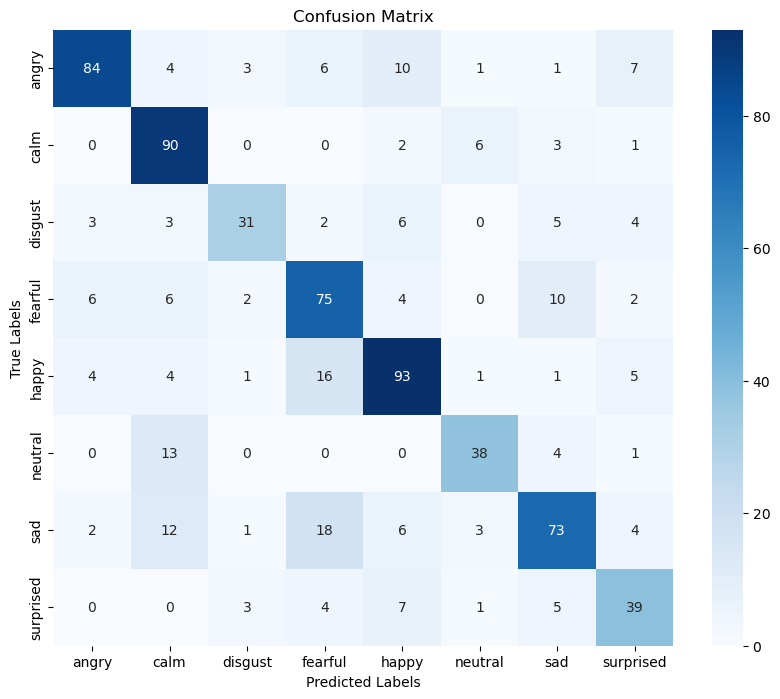

In [274]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

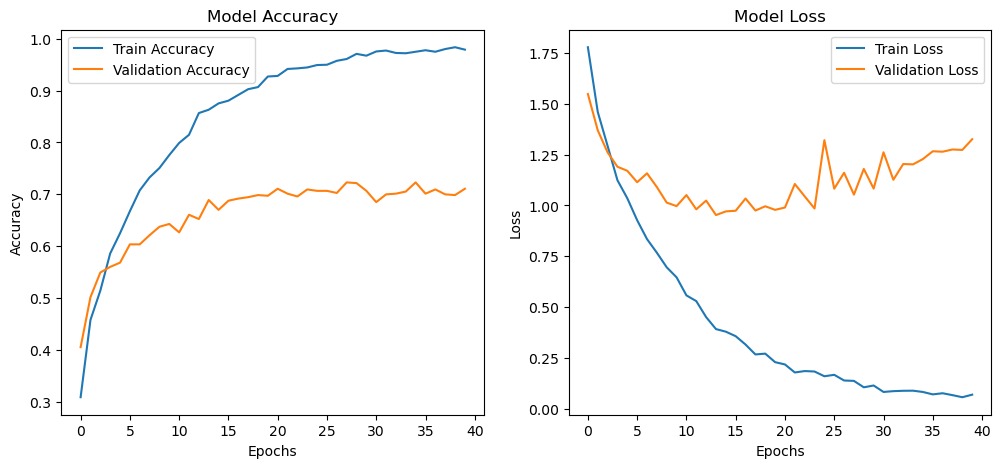

In [276]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()